In [16]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

class LinearRegression:
    def __init__(self, X, y, learning_rate, tolerance, max_iterations, SGDiterations, gd=False, sgd=False, regularizer=False, ridge=False, batch_size=100, lambda_param=0.5):
        self.X = X
        self.y = y
        self.tolerance = tolerance
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.gd = gd
        self.sgd = sgd
        self.regularizer = regularizer
        self.ridge = ridge
        self.batch_size = batch_size
        self.lambda_param = lambda_param
        self.SGDiterations = SGDiterations
        self.errors = []

    def split_train_test(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=0)
        return X_train, X_test, y_train, y_test

    def add_bias_term(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize_data(self, X):
        mean = np.mean(X, 0)
        std = np.std(X, 0)
        X_norm = (X - mean) / std
        X_norm = self.add_bias_term(X_norm)
        return X_norm, mean, std

    def normalize_testing_data(self, X, meanT, stdT):
        X_norm = (X - meanT) / stdT
        X_norm = self.add_bias_term(X_norm)
        return X_norm

    def ridge_penalty(self, weights):
        return self.lambda_param * 0.5 * np.linalg.norm(weights[1:], 2)

    def gradient_ridge_term(self, weights):
        gradient_penalty = np.asarray(self.lambda_param) * weights
        # Insert 0 for bias term.
        return np.insert(gradient_penalty, 0, 0, axis=0)

    def full_rank_check(self, X):
        X_rank = np.linalg.matrix_rank(X)
        if X_rank == min(X.shape[0], X.shape[1]):
            self.full_rank = True
            print('Dataset is a Full Rank Matrix')
        else:
            self.full_rank = False
            print('Dataset is not a Full Rank Matrix')

    def low_rank_check(self, X):
        if X.shape[0] < X.shape[1]:
            self.low_rank = True
            print("Dataset is a Low Rank Matrix")
        else:
            self.low_rank = False
            print("Dataset is not a Low Rank Matrix")

    def closed_form_solution(self, X, y):
        weights = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        return weights

    def sg_sample(self, X, y):
        n_obs = X.shape[0]
        xy = np.c_[X.reshape(n_obs, -1), y.reshape(n_obs, 1)]
        rng = np.random.default_rng(seed=None)
        rng.shuffle(xy)
        if not 0 < self.batch_size <= n_obs:
            raise ValueError(f"'batch_size' must be greater than 'Zero' and less than or equal to the number of observations, which is {n_obs}")
        start = random.randint(0, n_obs - self.batch_size)
        stop = start + self.batch_size
        x_batch, y_batch = xy[start:stop, :-1], xy[start:stop, -1:]
        y_batch = y_batch.reshape(-1)
        return x_batch, y_batch

    def gradient_descent(self, X, y):
        self.errors = []
        last_error = float('inf')
        if self.sgd:
            print("Using Stochastic Gradient Descent Method")
        else:
            print("Using Gradient Descent Method")
        gd_reg = 0
        reg_term = 0
        for t in tqdm(range(self.max_iterations)):
            if self.sgd:
                X_batch, y_batch = self.sg_sample(X, y)
            else:
                X_batch, y_batch = X, y
            if self.ridge:
                gd_reg = self.gradient_ridge_term(self.weights[1:])
                reg_term = self.ridge_penalty(self.weights[1:])
            self.weights = self.weights - self.learning_rate * (self.cost_derivative(X_batch, y_batch) + gd_reg)
            current_error = self.rmse_function(X_batch, y_batch) + reg_term
            difference = last_error - current_error
            last_error = current_error
            self.errors.append(current_error)
            if abs(difference) < self.tolerance:
                print("The model has converged, and no further improvements can be made.")
                break

    def stochastic_gradient_descent(self):
        self.errors = []  # Clear errors for SGD
        lastError = float('inf')
        reg_term = 0
        gd_reg = np.zeros(self.X_train.shape[1])  # Initialize gd_reg with zeros
        if self.ridge:
            gd_reg[1:] = self.gradient_ridge_term(
                self.weights[1:])  # Set the regularization term for weights other than the bias term
            reg_term = self.ridge_penalty(self.weights[1:])
        for t in range(self.SGDiterations):
            X_batch, y_batch = self.sg_sample(self.X_train, self.y_train)
            self.weights = self.weights - self.learning_rate * (self.cost_derivative(X_batch, y_batch) + gd_reg)
            cur = self.rmse_function(X_batch, y_batch) + reg_term
            diff = lastError - cur
            lastError = cur
            self.errors.append(cur)
            if abs(diff) < self.tolerance:
                print("The model has stopped, and no further improvements can be made here.")
                break

    def predict(self, X):
        if X.shape[1] != self.weights.shape[0]:
            print("Number of features in X does not match the number of features used for training.")
            # Adjust the weights vector based on the number of features in X
            if X.shape[1] < self.weights.shape[0]:
                self.weights = self.weights[:X.shape[1]]
            else:
                self.weights = np.concatenate((self.weights, np.zeros(X.shape[1] - self.weights.shape[0])))
        return X.dot(self.weights)

    def sse_function(self, X, y):
        y_pred = self.predict(X)
        return ((y_pred - y) ** 2).sum()

    def rmse_function(self, X, y):
        n = X.shape[0]
        return np.sqrt(self.sse_function(X, y) / n)

    def cost_function(self, X, y):
        return self.sse_function(X, y) / 2

    def cost_derivative(self, X, y):
        y_pred = self.predict(X)
        return (y_pred - y).dot(X)

    def plot_rmse(self, rmse_values=None):
        if rmse_values is None:
            rmse_values = self.errors
        plt.plot(range(len(rmse_values)), rmse_values)
        plt.title('Iterations verses Cost')
        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.show()

    def fit(self):
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_train_test()
        self.X_train, meanT, stdT = self.normalize_data(self.X_train)

        # Normalize and add bias term to test data using the same mean and std as training data
        self.X_test = self.normalize_testing_data(self.X_test, meanT, stdT)

        self.low_rank_check(self.X_train)
        self.full_rank_check(self.X_train)

        if self.full_rank and not self.low_rank and not self.gd and not self.sgd and self.X_train.shape[0] < 10000:
            print('Solving using normal equation...')
            self.weights = self.closed_form_solution(self.X_train, self.y_train)
        elif self.gd and not self.sgd:
            print('Solving using gradient descent...')
            self.weights = np.ones(self.X_train.shape[1], dtype=np.float64) * 0
            self.gradient_descent(self.X_train, self.y_train)  # Use gradientDescent method instead
        else:
            print('Solving using stochastic gradient descent...')
            self.weights = np.zeros(self.X_train.shape[1], dtype=np.float64)
            self.stochastic_gradient_descent()
        self.error_function()

    def error_function(self):
        sse_test = self.sse_function(self.X_test, self.y_test)
        rmse_test = self.rmse_function(self.X_test, self.y_test)
        print(f"SSE Error is {sse_test} and RMSE Error is {rmse_test}")



In [17]:
concrete_data = pd.read_csv("concreteData.csv")
housing_data  = pd.read_csv("housing.csv")
yacht_data =  pd.read_csv("yachtData.csv")

In [18]:
housing_regression_normal = LinearRegression(X = housing_data.values[:, 0:-1], y = housing_data.values[:, -1],regularizer=1,
                             learning_rate=0.0004, tolerance=0.005,SGDiterations = 100, batch_size= 1,
                              gd = False ,sgd = False, max_iterations=50000)

housing_regression_normal.fit()



Dataset is not a Low Rank Matrix
Dataset is a Full Rank Matrix
Solving using normal equation...
SSE Error is 3250.0044107893395 and RMSE Error is 4.624025082730341


In [19]:
housing_regression_gd = LinearRegression(X = housing_data.values[:, 0:-1], y = housing_data.values[:, -1],regularizer=1,
                             learning_rate=0.0001, tolerance=0.00005,SGDiterations = 100, batch_size= 1,
                              gd = True ,sgd = False, max_iterations=50000)

housing_regression_gd.fit()




Dataset is not a Low Rank Matrix
Dataset is a Full Rank Matrix
Solving using gradient descent...
Using Gradient Descent Method


  1%|          | 436/50000 [00:00<00:02, 21650.33it/s]

The model has converged, and no further improvements can be made.
SSE Error is 3275.5585195851836 and RMSE Error is 4.6421683621486745


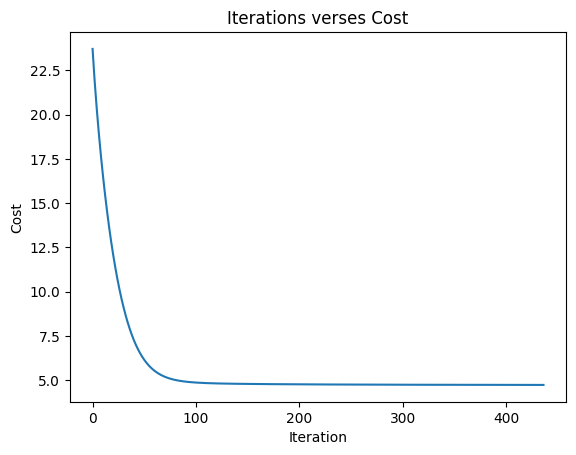

In [20]:
housing_regression_gd.plot_rmse()

In [21]:
  housing_regression_sgd = LinearRegression(X = housing_data.values[:, 0:-1], y = housing_data.values[:, -1],regularizer=1,
                             learning_rate=0.0004, tolerance=0.005,SGDiterations = 100, batch_size= 1,
                              gd = False ,sgd = True, max_iterations=50000)

housing_regression_sgd.fit()




Dataset is not a Low Rank Matrix
Dataset is a Full Rank Matrix
Solving using stochastic gradient descent...
SSE Error is 75343.84622553788 and RMSE Error is 22.263943919535524


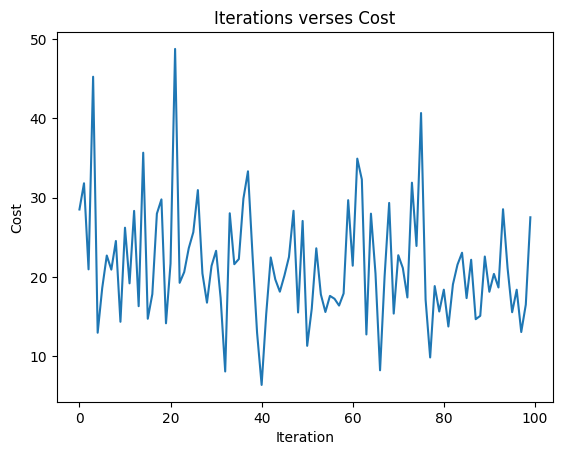

In [22]:
housing_regression_sgd.plot_rmse()

In [23]:
yacht_regression_normal = LinearRegression(X = yacht_data.values[:, 0:-1], y = yacht_data.values[:, -1],regularizer=1,
                             learning_rate=0.001, tolerance=0.001,SGDiterations = 100, batch_size= 1,
                              gd = False ,sgd = False, max_iterations=50000)

yacht_regression_normal.fit()



Dataset is not a Low Rank Matrix
Dataset is a Full Rank Matrix
Solving using normal equation...
SSE Error is 7619.253689071981 and RMSE Error is 9.051378846467502


In [24]:
yacht_regression_gd = LinearRegression(X = yacht_data.values[:, 0:-1], y = yacht_data.values[:, -1],regularizer=30,
                             learning_rate=0.001, tolerance=0.001,SGDiterations = 100, batch_size= 1,
                              gd = True ,sgd = False, max_iterations=50000)

yacht_regression_gd.fit()


Dataset is not a Low Rank Matrix
Dataset is a Full Rank Matrix
Solving using gradient descent...
Using Gradient Descent Method


  0%|          | 19/50000 [00:00<00:06, 7444.35it/s]

The model has converged, and no further improvements can be made.
SSE Error is 7569.43562991217 and RMSE Error is 9.021739353738697


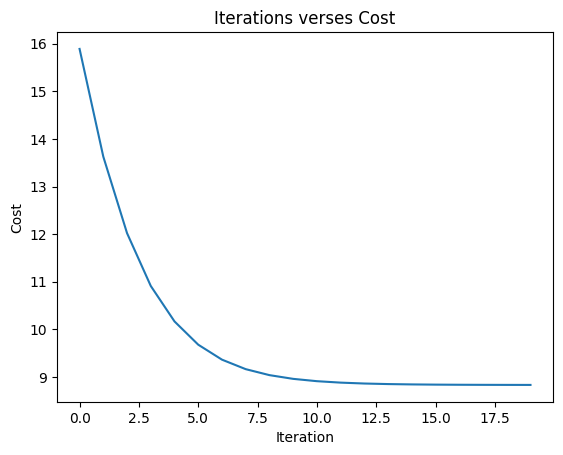

In [25]:
yacht_regression_gd.plot_rmse()

In [26]:
yacht_regression_sgd = LinearRegression(X = yacht_data.values[:, 0:-1], y = yacht_data.values[:, -1],regularizer=30,
                             learning_rate=0.001, tolerance=0.001,SGDiterations = 100, batch_size= 1,
                              gd = False ,sgd = True, max_iterations=50000)

yacht_regression_sgd.fit()




Dataset is not a Low Rank Matrix
Dataset is a Full Rank Matrix
Solving using stochastic gradient descent...
SSE Error is 22614.884445130254 and RMSE Error is 15.593934733904447


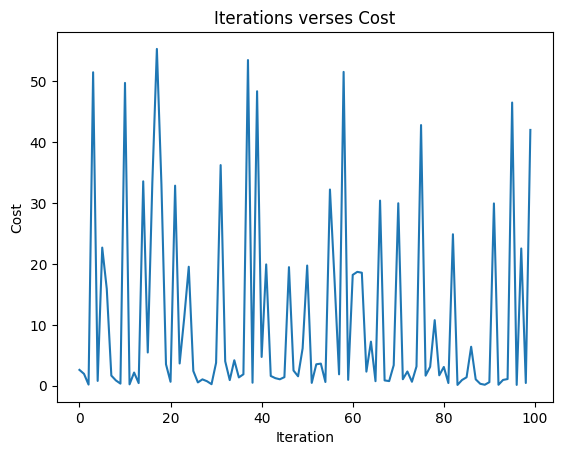

In [27]:
yacht_regression_sgd.plot_rmse()

In [28]:
concrete_regression_normal = LinearRegression(X = concrete_data.values[:, 0:-1], y = concrete_data.values[:, -1],regularizer=1,
                             learning_rate=0.0007, tolerance=0.0001,SGDiterations = 100, batch_size= 1,
                              gd = False ,sgd = False, max_iterations=50000)

concrete_regression_normal.fit()



Dataset is not a Low Rank Matrix
Dataset is a Full Rank Matrix
Solving using normal equation...
SSE Error is 38115.41391778251 and RMSE Error is 11.106342967100199


In [29]:
concrete_regression_gd = LinearRegression(X = concrete_data.values[:, 0:-1], y = concrete_data.values[:, -1],regularizer=9**3,
                             learning_rate=0.0007, tolerance=0.0001,SGDiterations = 100, batch_size= 1,
                              gd = True ,sgd = False, max_iterations=50000)

concrete_regression_gd.fit()


Dataset is not a Low Rank Matrix
Dataset is a Full Rank Matrix
Solving using gradient descent...
Using Gradient Descent Method


  0%|          | 140/50000 [00:00<00:04, 10757.19it/s]

The model has converged, and no further improvements can be made.
SSE Error is 38079.32142039327 and RMSE Error is 11.101083276157572


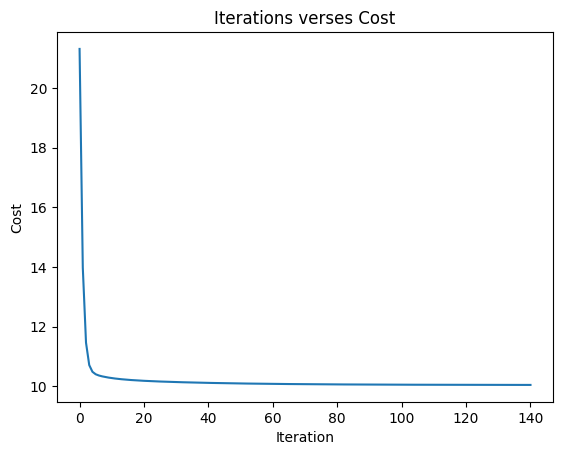

In [31]:
concrete_regression_gd.plot_rmse()



Dataset is not a Low Rank Matrix
Dataset is a Full Rank Matrix
Solving using stochastic gradient descent...
SSE Error is 427266.0427688695 and RMSE Error is 37.18518525553222


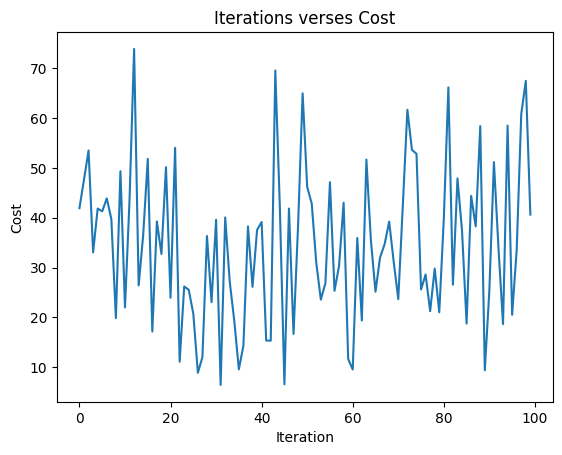

In [32]:
concrete_regression_sgd = LinearRegression(X = concrete_data.values[:, 0:-1], y = concrete_data.values[:, -1],regularizer=9**3,
                             learning_rate=0.0007, tolerance=0.0001,SGDiterations = 100, batch_size= 1,
                              gd = False ,sgd = True, max_iterations=50000)

concrete_regression_sgd.fit()
concrete_regression_sgd.plot_rmse()